# Plan

1. We can narrow down the list of companies by filtering out those with many missing values in the ycharts operating margin dataset.
1. Next, we can use the yfinance python library to check which of the remaining companies have stock prices available in the yfinance dataset.
1. Finally, we can use ycharts to obtain the turnover for the companies that passed both filters.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf


In [2]:
import json

with open("./data/ych_filtered_tickers.json") as jsf:
    ych_filtered_tickers = json.load(jsf)

ychopmdf = (
    pd.read_csv(
        "data/ycharts_opm/ycharts_opm_filtered_for_use.csv",
        parse_dates=True,
        index_col=0,
    )
    .sort_index(axis=1)
    .sort_index(axis=0)
    .drop("2009-04-01")
)


In [3]:
ych_filtered_tickers[:5]


['A', 'AACAF', 'AACAY', 'AAGRY', 'AAHIF']

In [4]:
ychopmdf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2010-04-01 to 2022-04-01
Columns: 4179 entries, A to SEKEY
dtypes: float64(4179)
memory usage: 424.5 KB


In [5]:
# Input Start and End Date
start = datetime(2010, 1, 1)
end = datetime(2022, 5, 1)

In [6]:
CACHE_PATH = "./data/yf/stocks3m_yf.csv.xz"

In [7]:
# stocks_yf = (
#     yf.download(
#         tickers=ych_filtered_tickers,
#         interval="3mo",
#         start=start,
#         end=end,
#         progress=False,
#         show_errors=False,
#     )
#     .loc[:, ["Adj Close", "Volume"]]
#     .rename({"Adj Close": "adj_close", "Volume": "volume"}, axis=1)
#     .sort_index()
#     .query("index.dt.month == 4")
# )

# tdf.to_csv(path_or_buf=CACHE_PATH, compression="xz", index=True)

In [8]:
stocks_yf = (
    pd.read_csv(
        filepath_or_buffer=CACHE_PATH,
        compression="xz",
        header=[0, 1],
        index_col=[
            0,
        ],
        parse_dates=True,
    )
    .sort_index(axis=0)
    .sort_index(axis=1)
    .drop("2009-04-01")
)

In [9]:
stocks_yf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2010-04-01 to 2022-04-01
Columns: 8358 entries, ('adj_close', 'A') to ('volume', 'SEKEY')
dtypes: float64(8358)
memory usage: 849.0 KB


In [10]:
stocks_yf.index

DatetimeIndex(['2010-04-01', '2011-04-01', '2012-04-01', '2013-04-01',
               '2014-04-01', '2015-04-01', '2016-04-01', '2017-04-01',
               '2018-04-01', '2019-04-01', '2020-04-01', '2021-04-01',
               '2022-04-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [11]:
stocks_yf.head(2)

adj_close                                                   
                    A     AACAF     AACAY AAGRY AAHIF       AAL AALBF   
Date                                                                    
2010-04-01  18.561193  0.516898       NaN   NaN   NaN  8.117004   NaN  \
2011-04-01  33.368343  1.173043  1.919609   NaN   NaN  8.399828   NaN   

                                            ... volume                      
                AAON        AAP       AAPL  ...  SECYF          SEE SEFJF   
Date                                        ...                             
2010-04-01  6.138316  47.825378   7.724693  ...    NaN   87188600.0   NaN  \
2011-04-01  8.756047  55.970848  10.308702  ...    NaN  108988100.0   NaN   

                                                                  
            SEGXF SEHLF        SEIC SEIGF SEIGY SEKEF      SEKEY  
Date                                                              
2010-04-01    0.0   NaN  80496800.0   NaN   NaN   NaN  2621000.0  
2011-04-01  700.0   NaN  51643100.0   NaN   NaN   NaN  2358600.0  

[2 rows x 8358 columns]

In [12]:
prices, volume = stocks_yf.loc[:, "adj_close"], stocks_yf.loc[:, "volume"]

Check, whether YF prices and volumes have the same NaNs:


In [13]:
# check if there is any cell where one dataframe has a NaN
# value while the other dataframe has a non-NaN value

mask_na = prices.isna() != volume.isna()
if mask_na.any().any():  # type: ignore
    print(
        "One of the dataframes has a NaN value in some cell where the other dataframe has the nonNaN value in the same cell."
    )
else:
    print("Both dataframes have the same NaN values.")

Both dataframes have the same NaN values.


In [14]:
prices.max().sort_values(ascending=False)[:10]


PIFMF     2.631339e+15
KIMTF     2.372910e+10
DENKF     7.194428e+06
NTDOF     1.023533e+04
JAG.TO    8.082482e+03
JAGGF     7.936038e+03
JPRRF     7.565915e+03
BLHWF     6.100000e+03
NVR       4.973300e+03
SAPMY     4.922488e+03
dtype: float64

In [15]:
yf.Ticker("NVR").get_info()


{'address1': 'Plaza America Tower I',
 'address2': 'Suite 500 11700 Plaza America Drive',
 'city': 'Reston',
 'state': 'VA',
 'zip': '20190',
 'country': 'United States',
 'phone': '703 956 4000',
 'website': 'https://www.nvrinc.com',
 'industry': 'Residential Construction',
 'industryDisp': 'Residential Construction',
 'sector': 'Consumer Cyclical',
 'longBusinessSummary': 'NVR, Inc. operates as a homebuilder in the United States. The company operates through, Homebuilding and Mortgage Banking segments. It engages in the construction and sale of single-family detached homes, townhomes, and condominium buildings under the Ryan Homes, NVHomes, and Heartland Homes names. The company markets its Ryan Homes products to first-time and first-time move-up buyers; and NVHomes and Heartland Homes products to move-up and luxury buyers. It also provides various mortgage related services to its homebuilding customers, as well as brokers title insurance; performs title searches in connection with m

Check, whether yf dataset have discrepancies with ycharts_opm dataset:


<Axes: ylabel='date'>

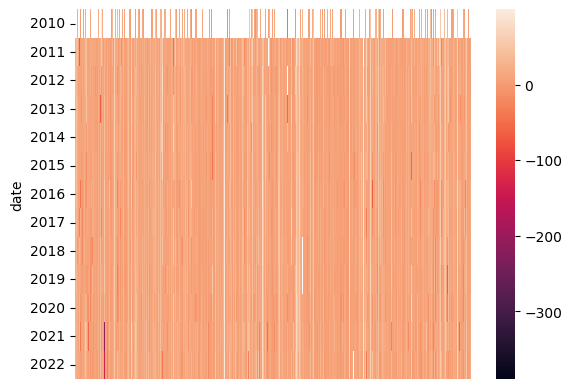

In [16]:
sns.heatmap(ychopmdf, xticklabels=False, yticklabels=ychopmdf.index.year)  # type: ignore

<Axes: ylabel='Date'>

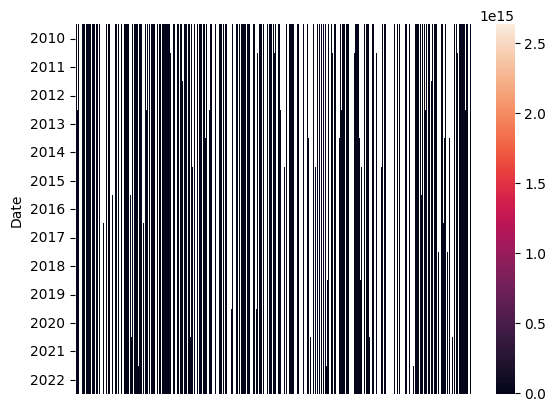

In [17]:
plt.clf()
sns.heatmap(prices, xticklabels=False, yticklabels=prices.index.year)  # type: ignore

In [18]:
all(ychopmdf.columns == prices.columns)

True

In [19]:
all(ychopmdf.index == prices.index)

True

<Axes: xlabel='Number of misses across two datasets', ylabel='Frequency'>

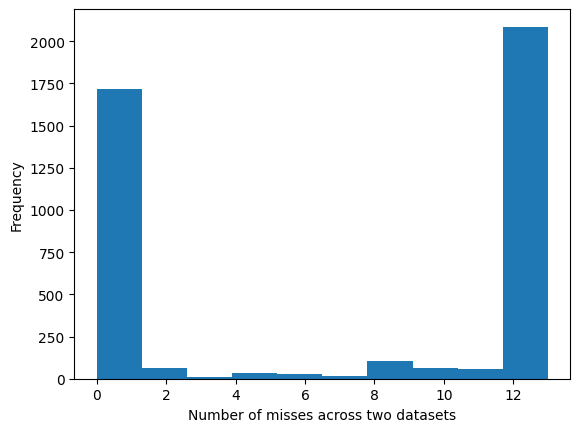

In [20]:
# returns mask, True means the value is present in both DFs
mask_cna = ~(prices.isna() | ychopmdf.isna())
mask_cna.sum().plot(kind="hist", xlabel="Number of misses across two datasets")

In [21]:
mask_cna.sum(1)


Date
2010-04-01     309
2011-04-01    2092
2012-04-01    2146
2013-04-01    2208
2014-04-01    2261
2015-04-01    2310
2016-04-01    2322
2017-04-01    2351
2018-04-01    2370
2019-04-01    2388
2020-04-01    2395
2021-04-01    2452
2022-04-01    2472
dtype: int64

<Axes: ylabel='Date'>

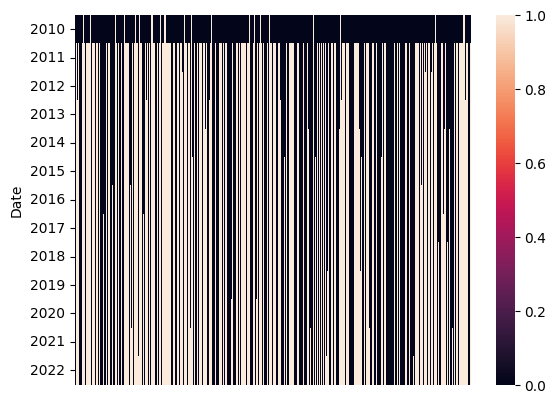

In [22]:
sns.heatmap(mask_cna, xticklabels=False, yticklabels=prices.index.year)  # type: ignore

We want to drop all companies, that have more then 2 NaNs.


In [23]:
tickers_to_drop = mask_cna.sum()[mask_cna.sum() < 13 - 2].index.to_list()
len(tickers_to_drop)


2033

Here I select values that are present only in both dataframes `.where(mask_cna, other=np.nan)`, then drop columns with companies, that have more then 2 NaNs `.drop(tickers_to_drop, axis=1)`:


In [24]:
prices = prices.where(mask_cna, other=np.nan).drop(tickers_to_drop, axis=1)  # type: ignore
volume = volume.where(mask_cna, other=np.nan).drop(tickers_to_drop, axis=1)  # type: ignore
ychopmdf = ychopmdf.where(mask_cna, other=np.nan).drop(tickers_to_drop, axis=1)  # type: ignore


In [25]:
ychopmdf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2010-04-01 to 2022-04-01
Columns: 2146 entries, A to SEKEY
dtypes: float64(2146)
memory usage: 218.1 KB


In [26]:
from json import dump

with open("data/yf/new_tickers_2146.json", "w") as f:
    dump(ychopmdf.columns.to_list(), f)


In [32]:
(volume > 20_000_000).sum(1)


Date
2010-04-01     26
2011-04-01    754
2012-04-01    773
2013-04-01    751
2014-04-01    758
2015-04-01    758
2016-04-01    800
2017-04-01    802
2018-04-01    820
2019-04-01    817
2020-04-01    924
2021-04-01    844
2022-04-01    522
dtype: int64

<Axes: >

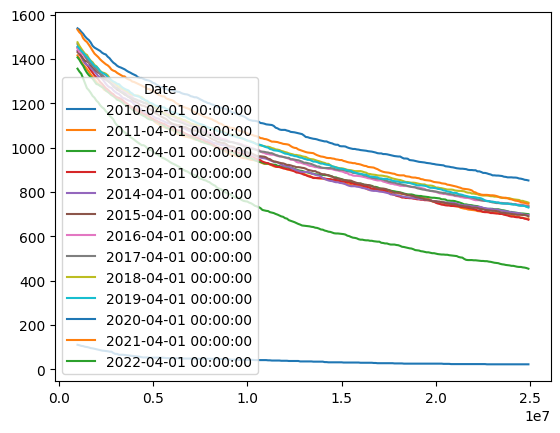

In [49]:
vol_range = range(1_000_000, 25_000_000, 100_000)

remains_series = pd.concat(
    [(volume > thr).sum(1) for thr in vol_range],
    axis=1,
)

remains_series.columns = list(vol_range)
# remains_series.head()
remains_series.T.plot()

In [54]:
yf.Ticker("NVR").financials

Exception: yfinance failed to decrypt Yahoo data response